In [3]:
'''
This script loads the timeseries data from the listening and reading
hyperscanning control tasks, and visualizes the data in various ways
with the goal of trying to elucidate why we see so many negative
correlations between individual timeseries and averaged timeseries
from the rest of the group.

To add:
look at just primary auditory cortex
'''

'\nThis script loads the timeseries data from the listening and reading\nhyperscanning control tasks, and visualizes the data in various ways\nwith the goal of trying to elucidate why we see so many negative\ncorrelations between individual timeseries and averaged timeseries\nfrom the rest of the group.\n\nTo add:\nlook at just primary auditory cortex\n'

In [4]:
import scipy.io as sio
import os
import sys
import numpy as np
import pandas as pd
import time
from joblib import Parallel, delayed
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi
sys.path.append('/afs/dbic.dartmouth.edu/usr/wheatley/jd/')
from phaseScramble import *
from CircleShift import *
from scipy.stats import norm
from sklearn import preprocessing
%matplotlib inline

In [5]:
# participant IDs
dbicIDs = np.array(["sid000007", "sid000009", "sid000560", "sid000535", "sid000102", "sid000416", "sid000499", "sid000142"])
cbsIDs = np.array(["hid000002", "hid000003", "hid000004", "hid000005", "hid000006", "hid000007", "hid000008", "hid000009"])

# pair numbers
pairNums = np.arange(2,len(dbicIDs)+2)

# make subject list data frame
subList = pd.DataFrame(np.transpose(np.tile(pairNums, (1, 2))),columns=['pairNum'])
subList['subID'] = np.concatenate((dbicIDs, cbsIDs), axis=0)
print(subList)

# get number of participants
numSubs = len(pairNums) * 2

# set fitting distribution to normal
dist = getattr(stats, 'norm')

# define condition labels
taskNames = np.array(['listening','reading'])
normNames = np.array(['',', norm'])
siteNames = np.array(['DBIC','CBS'])

# set whether or not to export html
exportHtml = False

    pairNum      subID
0         2  sid000007
1         3  sid000009
2         4  sid000560
3         5  sid000535
4         6  sid000102
5         7  sid000416
6         8  sid000499
7         9  sid000142
8         2  hid000002
9         3  hid000003
10        4  hid000004
11        5  hid000005
12        6  hid000006
13        7  hid000007
14        8  hid000008
15        9  hid000009


In [6]:
# set data folder
folder = '/afs/dbic.dartmouth.edu/usr/wheatley/jd/control_tasks/'

# loop through participants...
boldData = [[]] * 2
for TASK in [0,1]: #for each task, listening, then reading

    boldData[TASK] = [[]] * 2

    # preallocate a fake data list (don't need to do this for both tasks)
    if TASK == 0:
        fakeData = [[]] * 2

    for NORM in [0,1]: # 0 = no normalization, 1 = normalization

        # preallocate task data list
        boldData[TASK][NORM] = [[]] * numSubs
        if TASK == 0:
            fakeData[NORM] = [[]] * numSubs

        for SUB in range(numSubs):

            # get file name
            fileName = folder + 'sub-' + subList['subID'][SUB] + '_ses-pair0' + str(subList['pairNum'][SUB]) + '_task-storytelling' + str(TASK + 3) + '_run-0' + str(TASK + 3) + '_bold_space-MNI152NLin2009cAsym_preproc_nuisRegr_2021_interp.mat'

            if NORM == 0:
                # load real data
                tmp = sio.loadmat(fileName) #load file
                boldData[TASK][NORM][SUB] = tmp['tseries'] #get timeseries data
                print('loaded ' + str(boldData[TASK][NORM][SUB].shape[0]) + ' x ' + str(boldData[TASK][NORM][SUB].shape[1]) + ' timeseries for ' + taskNames[TASK] + ' task, sub ' + subList['subID'][SUB])

                # generate fake data with same dimensions as boldData
                if TASK == 0:
                    fakeData[NORM][SUB] = np.random.rand(boldData[TASK][NORM][SUB].shape[0],boldData[TASK][NORM][SUB].shape[1])
            else:
                # normalize
                boldData[TASK][NORM][SUB] = preprocessing.normalize(boldData[TASK][0][SUB])
                if TASK == 0:
                    fakeData[NORM][SUB] = preprocessing.normalize(fakeData[0][SUB])

loaded 487 x 69880 timeseries for listening task, sub sid000007
loaded 487 x 69880 timeseries for listening task, sub sid000009
loaded 487 x 69880 timeseries for listening task, sub sid000560
loaded 487 x 69880 timeseries for listening task, sub sid000535
loaded 487 x 69880 timeseries for listening task, sub sid000102
loaded 487 x 69880 timeseries for listening task, sub sid000416
loaded 487 x 69880 timeseries for listening task, sub sid000499
loaded 487 x 69880 timeseries for listening task, sub sid000142
loaded 487 x 69880 timeseries for listening task, sub hid000002
loaded 487 x 69880 timeseries for listening task, sub hid000003
loaded 487 x 69880 timeseries for listening task, sub hid000004
loaded 487 x 69880 timeseries for listening task, sub hid000005
loaded 487 x 69880 timeseries for listening task, sub hid000006
loaded 487 x 69880 timeseries for listening task, sub hid000007
loaded 487 x 69880 timeseries for listening task, sub hid000008
loaded 487 x 69880 timeseries for listen

In [7]:
corrData = [[]] * 2
for TASK in [0,1]: # for each task, listening, then reading

    corrData[TASK] = [[]] * 2

    # preallocate a fake data list (don't need to do this for both tasks)
    if TASK == 0:
        fakeCorrData = [[]] * 2

    for NORM in [0,1]: # for each normalization condition (not normalized, normalized)

        # preallocate task data list
        corrData[TASK][NORM] = [[]] * numSubs
        if TASK == 0:
            fakeCorrData[NORM] = [[]] * numSubs

        for SUB in range(numSubs): #for each subject

            # get mean of data from all participants EXCEPT the current participant
            otherSubs = np.arange(0,numSubs)
            otherSubs = np.delete(otherSubs,SUB)
            groupMean = np.mean([boldData[TASK][NORM][i] for i in otherSubs], axis=0)

            # get correlation between current participant and groupMean
            corrData[TASK][NORM][SUB] = fastColumnCorr(boldData[TASK][NORM][SUB], groupMean)
            print('computing correlation for sub ' + str(SUB + 1) + ', ' + taskNames[TASK] + ' task' + normNames[NORM])

            # fake data correlation
            if TASK == 0:
                groupMeanFake = np.mean([fakeData[NORM][i] for i in otherSubs], axis=0)
                fakeCorrData[NORM][SUB] = fastColumnCorr(fakeData[NORM][SUB], groupMeanFake)

computing correlation for sub 1, listening task
computing correlation for sub 2, listening task
computing correlation for sub 3, listening task
computing correlation for sub 4, listening task
computing correlation for sub 5, listening task
computing correlation for sub 6, listening task
computing correlation for sub 7, listening task
computing correlation for sub 8, listening task
computing correlation for sub 9, listening task
computing correlation for sub 10, listening task
computing correlation for sub 11, listening task
computing correlation for sub 12, listening task
computing correlation for sub 13, listening task
computing correlation for sub 14, listening task
computing correlation for sub 15, listening task
computing correlation for sub 16, listening task
computing correlation for sub 1, listening task, norm
computing correlation for sub 2, listening task, norm
computing correlation for sub 3, listening task, norm
computing correlation for sub 4, listening task, norm
computing

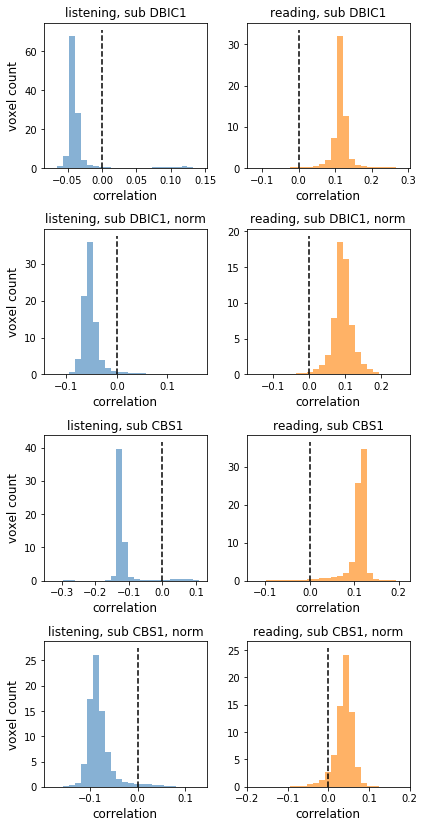

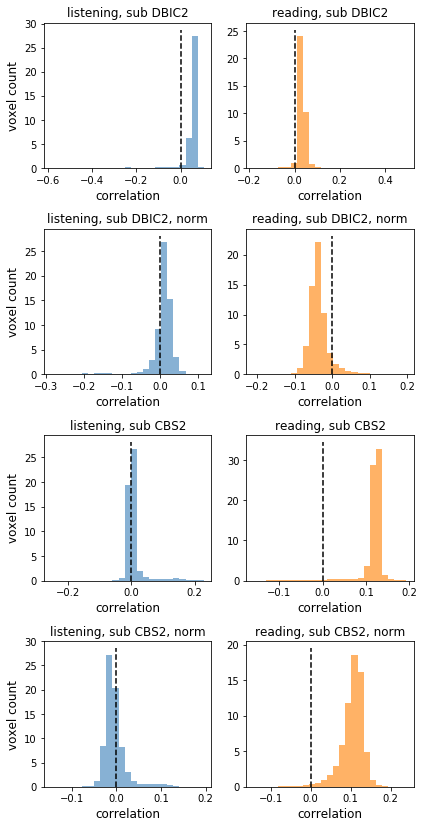

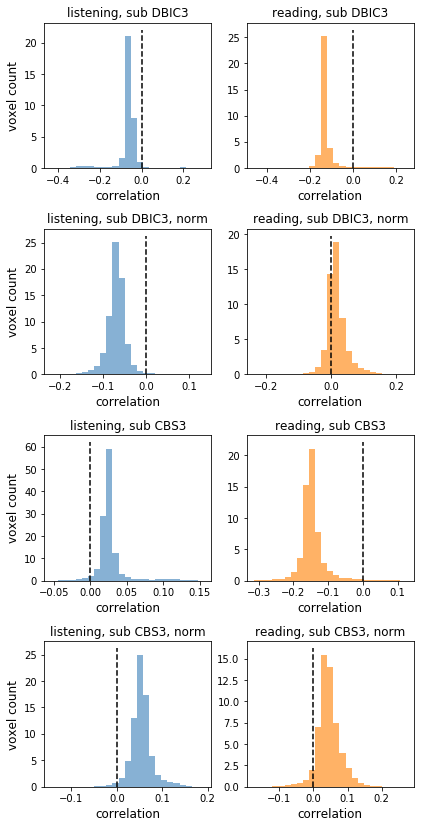

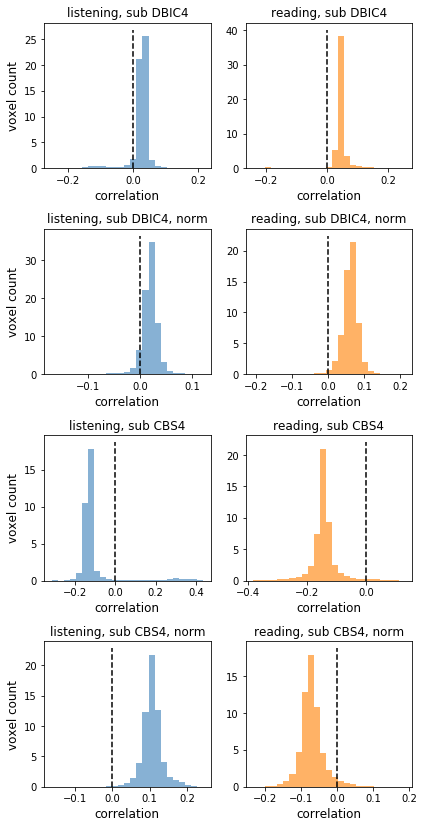

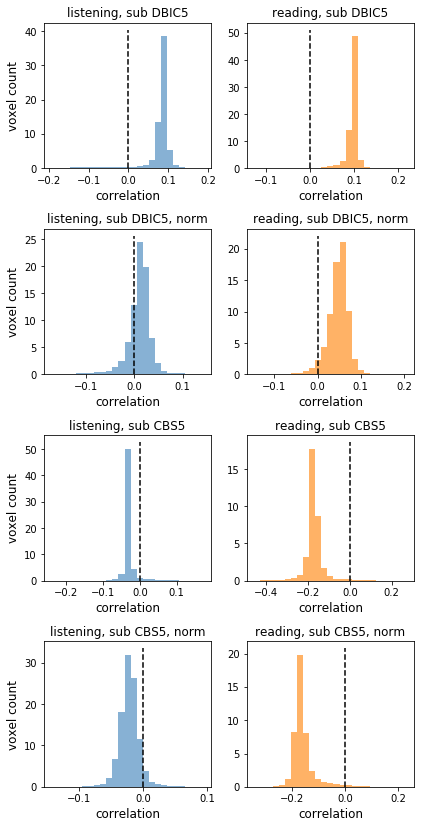

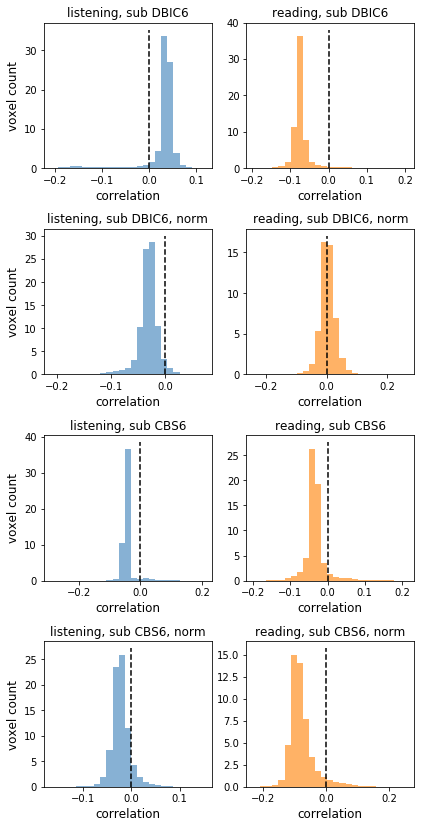

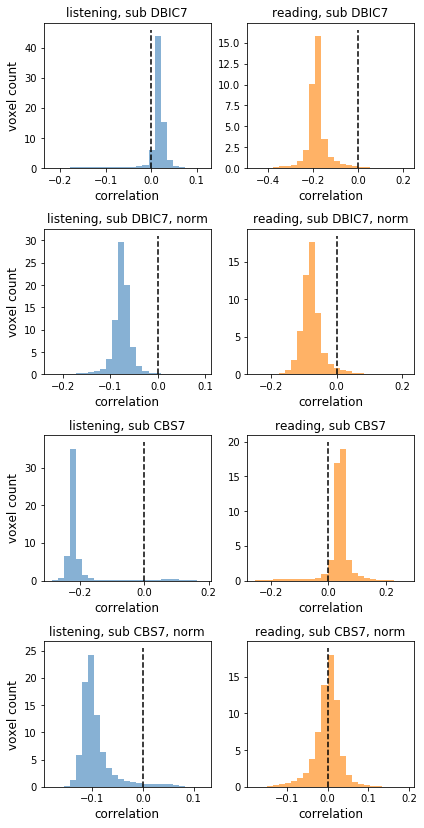

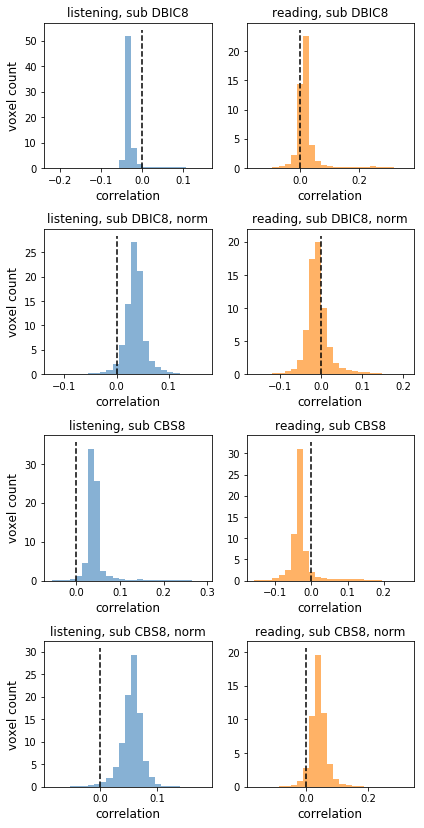

In [8]:
# get number of pairs
numPairs = round(numSubs / 2)

# include random data at the bottom?
randData = False

# make subplot map
if randData:
    spMap = np.arange(10).reshape(5,2) + 1
else:
    spMap = np.arange(8).reshape(4,2) + 1

# set axis label font size
axLabFontSize = 12

# colorblind-friendly colors list
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# set task colors
taskColors = CB_color_cycle[:2]

# plot data
for SUB in range(numPairs):

    # get subjects from current pair
    pairSubs = [SUB,SUB + round((numSubs / 2))]

    # initialize plot
    plt.figure(facecolor='white',figsize=(6,14))

    # for each subject in the current pair
    for PAIRSUB in [0,1]:

        for TASK in [0,1]:

            for NORM in [0,1]:

                # get plot data
                pData = corrData[TASK][NORM][pairSubs[PAIRSUB]]

                # select subplot
                plt.subplot(5, 2, spMap[NORM+PAIRSUB*2,TASK])
                # ax = fig.add_subplot(5, 2, spMap[NORM+PAIRSUB*2,TASK])

                # plot histogram
                plt.hist(pData, bins=25, density=True, alpha=0.6, color=taskColors[TASK])

                # dashed line at x=0
                yMax = plt.gca().get_ylim()[1]
                plt.plot([0, 0], [0, yMax], '--k')

                # axes and title
                plt.xlabel('correlation', fontsize=axLabFontSize)
                if TASK == 0:
                    plt.ylabel('voxel count', fontsize=axLabFontSize)
                plt.title(taskNames[TASK] + ', sub ' + siteNames[PAIRSUB] + str(SUB + 1) + normNames[NORM])

    plt.tight_layout()
    plt.show()

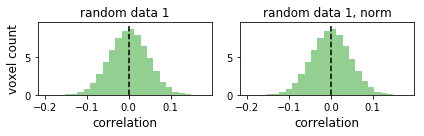

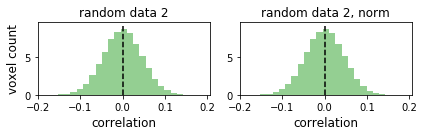

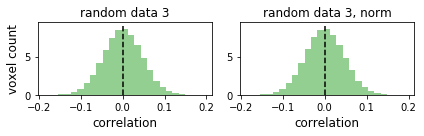

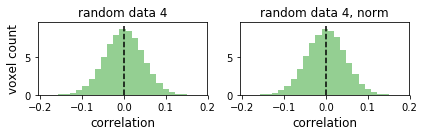

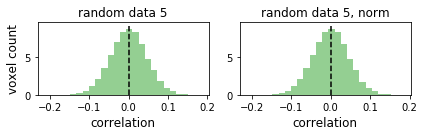

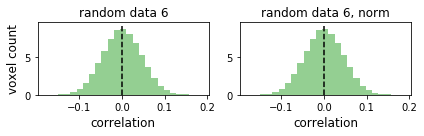

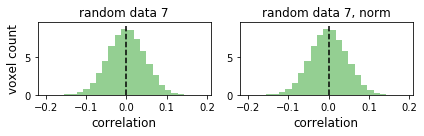

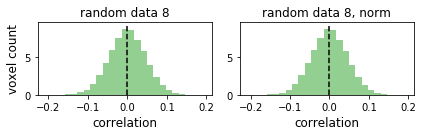

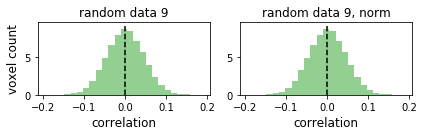

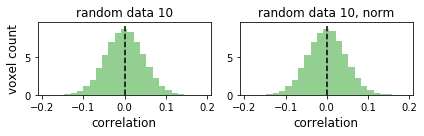

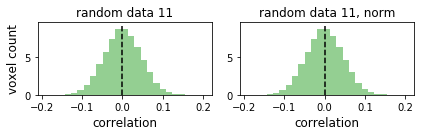

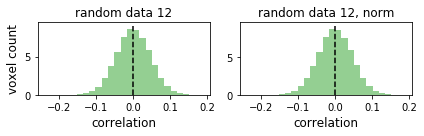

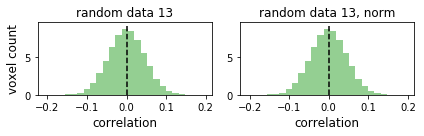

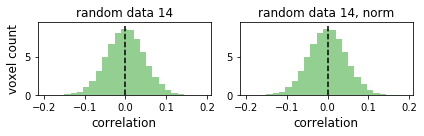

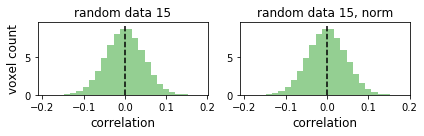

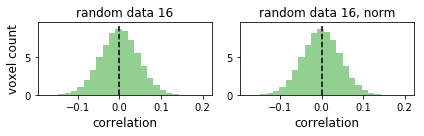

In [9]:
# set random data color
randDataColor = CB_color_cycle[2]

for SUB in range(numSubs):

    # initialize plot
    plt.figure(facecolor='white',figsize=(6,2))

    for NORM in [0,1]:

        # select subplot
        plt.subplot(1, 2, NORM + 1)

        # plot histogram
        plt.hist(fakeCorrData[NORM][SUB], bins=25, density=True, alpha=0.6, color=randDataColor)

        # dashed line at x=0
        yMax = plt.gca().get_ylim()[1]
        plt.plot([0, 0], [0, yMax], '--k')

        # axes labels and title
        plt.xlabel('correlation', fontsize=axLabFontSize)
        if NORM == 0:
            plt.ylabel('voxel count', fontsize=axLabFontSize)
        plt.title('random data ' + str(SUB + 1) + normNames[NORM])

    plt.tight_layout()
    plt.show()

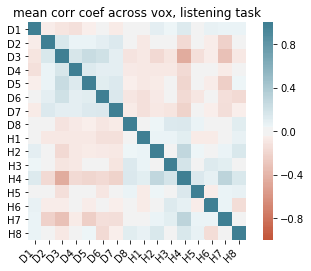

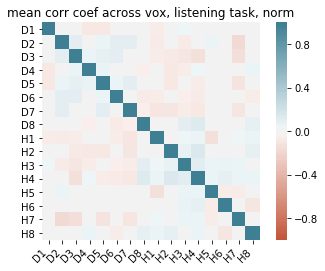

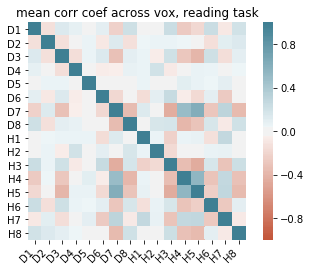

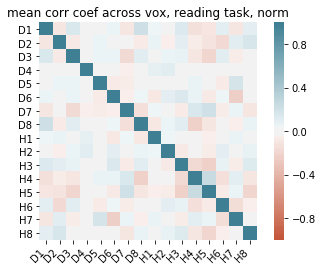

In [10]:
import seaborn as sns

corrMat = [[]] * 2
corrColors = [[]] * 2
axLab = [[]] * numSubs
for TASK in [0,1]:

    corrMat[TASK] = [[]] * 2
    corrColors[TASK]= [[]] * 2

    for NORM in [0,1]:

        # preallocate subs x subs correlation matrix
        corrMat[TASK][NORM] = np.empty([numSubs,numSubs])
        corrColors[TASK][NORM] = np.empty([numSubs,numSubs])

        for SUB1 in range(numSubs):

            if TASK == 0 & NORM == 0:
                if SUB1 < numPairs:
                    axLab[SUB1] = 'D' + str(SUB1 + 1)
                else:
                    axLab[SUB1] = 'H' + str(SUB1 - numPairs + 1)

            for SUB2 in range(numSubs):

                corrMat[TASK][NORM][SUB1,SUB2] = np.mean(fastColumnCorr(boldData[TASK][NORM][SUB1], boldData[TASK][NORM][SUB2]))

        plt.figure(facecolor='white')
        ax = sns.heatmap(
            corrMat[TASK][NORM],
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True
        )
        ax.set_xticklabels(axLab)
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=45,
            horizontalalignment='right'
        )
        ax.set_yticklabels(axLab)
        ax.set_yticklabels(
            ax.get_yticklabels(),
            rotation=0
        )
        plt.title('mean corr coef across vox, ' + taskNames[TASK] + ' task' + normNames[NORM])

In [25]:
if exportHtml:
    os.chdir('/afs/dbic.dartmouth.edu/usr/wheatley/jd')
    os.system('jupyter nbconvert --to html control_ISC_correlation_mystery.ipynb')

In [23]:
os.getcwd()

True


'/afs/.dbic.dartmouth.edu/usr/wheatley/jd'

[NbConvertApp] WARNING | pattern 'control_ISC_correlation_mystery.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--generate-config
    generate default config file
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--debug
    set log level to logging.DEBUG (maximize logging output)
--inplace
    Run nbconvert in place, overwriting the existing notebook (only 
    relevant when converting to notebook format)
--st